## Validation of irrigated extent
Generating a confusion matrix

Relying on Claire Kraus's notebook for guidance:

https://github.com/GeoscienceAustralia/dea-notebooks/blob/ClaireK/Crop_mapping/NamoiPilotProjectWorkflow/ValidateAutomaticIrrigatedCropAreaGeotiffs.ipynb

In [68]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools
from transform_tuple import transform_tuple

### User Inputs

In [65]:
#provide the filepaths to the irrigated cropping extent tif and the validation shapefile
irrigated = "/g/data1a/r78/cb3058/dea-notebooks/ICE_project/results/Peel_s2_Summer2018-19/Peel_s2_Summer2018-19_10m_600pixels_Irrigated.tif"

validation = "/g/data1a/r78/cb3058/dea-notebooks/ICE_project/results/Peel_s2_Summer2018-19/namoi_validation.shp"

#what year are we validating
year = '2018-19'

#### Open data and convert to boolean arrays

In [48]:
AutomaticCropBoolean  = xr.open_rasterio(irrigated)
AutomaticCropBoolean  = AutomaticCropBoolean.drop('band').squeeze()
AutomaticCropBoolean  = np.isfinite(AutomaticCropBoolean.values)

In [57]:
#need to convert validation shapefile to array first
transform, projection = transform_tuple(test, (test.x, test.y), epsg=3577)
width,height = test.shape

ValidationMaskBoolean  = SpatialTools.rasterize_vector(validation, height, width,
                                            transform, projection, raster_path=None)

ValidationMaskBoolean  = control.astype(bool)

#### Compare the boolean arrays to create a confusion matrix

In [50]:
YesRealYesAuto = np.logical_and(AutomaticCropBoolean, ValidationMaskBoolean)
NoRealNoAuto = np.logical_and(~AutomaticCropBoolean, ~ValidationMaskBoolean)

YesRealNoAuto = np.logical_and(AutomaticCropBoolean, ~ValidationMaskBoolean)
NoRealYesAuto = np.logical_and(~AutomaticCropBoolean, ValidationMaskBoolean)

In [59]:
Correct_positives = YesRealYesAuto.sum()
Incorrect_positives = NoRealYesAuto.sum()
Correct_negatives = NoRealNoAuto.sum()
Incorrect_negatives = YesRealNoAuto.sum()

Totalpixels = (width * height)

Accuracy = (Correct_positives + Correct_negatives) / Totalpixels
Misclassification_rate = (Incorrect_positives + Incorrect_negatives) / Totalpixels
True_Positive_Rate = Correct_positives / ValidationMaskBoolean.sum()
False_Positive_Rate = Correct_positives / ((~ValidationMaskBoolean).sum())
Specificity = Correct_negatives / ((~ValidationMaskBoolean).sum())
Precision = Correct_positives / AutomaticCropBoolean.sum()
Prevalence = (ValidationMaskBoolean.sum() ) / Totalpixels

In [66]:
print('\033[1m' + '{0} Automatic Irrigated Crop Extent'.format(year) + '\033[0m')
print('Accuracy = %.2f' % Accuracy)
print('Misclassification_rate = %.2f' % Misclassification_rate)
print('True_Positive_Rate = %.2f' % True_Positive_Rate)
print('False_Positive_Rate = %.2f' % False_Positive_Rate)
print('Specificity = %.2f' % Specificity)
print('Precision = %.2f' % Precision)
print('Prevalence = %.2f' % Prevalence)

2018-19 Automatic Irrigated Crop Extent
Accuracy = 0.98
Misclassification_rate = 0.02
True_Positive_Rate = 0.16
False_Positive_Rate = 0.00
Specificity = 0.99
Precision = 0.32
Prevalence = 0.02


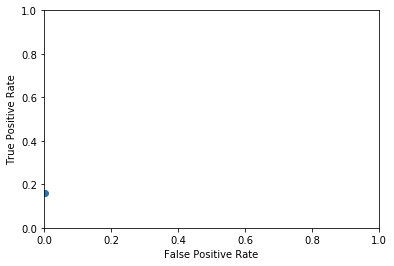

In [64]:
plt.figure()
plt.scatter(False_Positive_Rate, True_Positive_Rate)
plt.xlim ([0, 1]);
plt.ylim ([0, 1]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');